# UCPupeley
## Chandler Haukap, Carlos Moreno, and Autumn Rains

### Import libraries

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import requests
from PIL import Image
from io import BytesIO

### Define some helper functions

In [174]:
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_path(path):
  """Returns an image with shape [1, height, width, num_channels]."""
  image = Image.open(path)
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_path(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

def save_image(image, name):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.savefig(name,pad_inches=0,bbox_inches='tight')
  plt.close()

### Select a TensorFlowHub labeling model

In [175]:
image_size = 224
dynamic_size = False

model_name = "resnet_v2_152" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4"
}

model_image_size_map = {
  "resnet_v2_152": 224
}

model_handle = model_handle_map[model_name]

max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels[1:]]
  i += 1

Images will be converted to 224x224


### Load the data

2021-12-02 20:32:09.715617: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


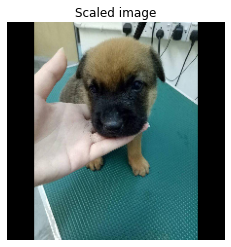

In [4]:
df = pd.read_csv("../data/train.csv")
image_path = "../data/train/" + df.Id[2] + ".jpg"
image = load_image(image_path, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

### Label the data

First, The model needs initialized

In [5]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

2021-12-02 20:32:16.940544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 3.72 s, sys: 339 ms, total: 4.06 s
Wall time: 3.5 s


Then we can test an image

CPU times: user 1.01 s, sys: 237 ms, total: 1.25 s
Wall time: 634 ms
True
(1)  225 - malinois: 0.8495094776153564
(2)  182 - Border terrier: 0.12605944275856018
(3)  255 - Leonberg: 0.02231677807867527
(4)  262 - Brabancon griffon: 0.0007704859017394483
(5)  235 - German shepherd: 0.0005434566410258412
(6)  174 - Norwegian elkhound: 0.0004126651620026678
(7)  202 - soft-coated wheaten terrier: 0.0001259345153812319
(8)  242 - boxer: 3.430302604101598e-05
(9)  192 - cairn: 3.33454372594133e-05
(10)  260 - chow: 3.1847794161876664e-05


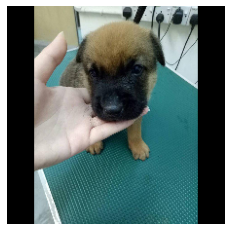

In [6]:
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:10].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001
print(includes_background_class)

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

Now the rest can get labeled

In [ ]:
results = np.stack(df.apply(lambda x: tf.nn.softmax(classifier(load_image("../data/train/" + x.Id + ".jpg", image_size, dynamic_size, max_dynamic_size))).numpy()[0][-1000:].tolist(), axis=1))
reduced_set = probs[probs.columns.difference(probs.columns[pd.DataFrame(probs.max() < 0.1)[0]])]
combined = pd.concat([df,reduced_set], axis=1)

And I'll save it because this operation is so time intensive.

In [ ]:
combined.to_csv("../data/train_augmented_reduced.csv")

### Flatten the data into "cat", "dog", and "neither"

In [118]:
df = pd.read_csv("./columns.csv")
df.columns

Index(['label', 'dog_or_cat'], dtype='object')

In [119]:
dog_or_cat_labels = pd.concat([df[df.dog_or_cat == "dog"], df[df.dog_or_cat == "cat"]])
dog_labels = df[df.dog_or_cat == "dog"]
cat_labels = df[df.dog_or_cat == "cat"]
df = pd.read_csv("../data/train_augmented_reduced.csv")

In [120]:
cat_or_dog_columns = df[dog_or_cat_labels.label]
cat_or_dog_columns.head()

,Afghan hound,African hunting dog,Airedale,American Staffordshire terrier,Appenzeller,Australian terrier,Bedlington terrier,Bernese mountain dog,Blenheim spaniel,Border collie,...,vizsla,whippet,wire-haired fox terrier,Angora,Egyptian cat,Madagascar cat,Persian cat,Siamese cat,tabby,tiger cat
0,5.924149e-08,2.822340e-09,4.652143e-05,7.644594e-03,2.773706e-06,2.309044e-06,2.361765e-07,8.601864e-08,4.359752e-07,8.074460e-09,...,1.146337e-05,1.340811e-06,1.516830e-06,8.544998e-10,2.330583e-08,1.336487e-08,5.024412e-09,2.033853e-08,5.347278e-08,3.732724e-08
1,1.222452e-05,1.456577e-05,2.341742e-05,2.950401e-06,3.446523e-05,1.919463e-05,2.388259e-05,7.982618e-06,1.585030e-05,4.047657e-05,...,3.414410e-05,2.329773e-05,7.745354e-05,1.639766e-05,6.094242e-02,2.063586e-04,5.846795e-04,1.342543e-04,2.576015e-02,5.725818e-02
2,8.867091e-09,2.379124e-05,4.703756e-09,9.376070e-07,4.637796e-09,5.741339e-09,2.531960e-09,4.850226e-10,8.836708e-11,1.313653e-10,...,2.698811e-10,1.771158e-07,6.075466e-09,1.937529e-09,6.024644e-10,1.348026e-09,3.445503e-10,9.911881e-07,7.427999e-10,7.347849e-10
3,4.309672e-08,2.430128e-08,6.550265e-05,2.318217e-02,1.197891e-06,3.472589e-06,1.206160e-01,3.780838e-07,4.089268e-06,1.366863e-05,...,7.760511e-06,1.418549e-05,4.001648e-02,5.999781e-06,1.352442e-04,7.294850e-07,5.619894e-07,3.999999e-06,1.586518e-06,5.039279e-07
4,2.635276e-09,7.021936e-07,8.131463e-09,2.058676e-03,2.527119e-05,4.974756e-07,1.441959e-07,1.296365e-07,2.516203e-07,1.723931e-04,...,1.011695e-06,2.071112e-04,1.369713e-07,1.821602e-08,1.163583e-05,3.145329e-07,1.503106e-08,3.222557e-05,6.910530e-08,1.640677e-07


In [121]:
is_cat_or_dog = cat_or_dog_columns.apply(lambda y: y.map(lambda t: t > 0.5))
is_cat_or_dog.describe()
dog = is_cat_or_dog[dog_labels.label].apply(lambda y: 1 if y.any() else 0, axis=1)
cat = is_cat_or_dog[cat_labels.label].apply(lambda y: 1 if y.any() else 0, axis=1)
cat_and_dog = pd.concat([cat, dog], axis=1)
cat_and_dog.columns = ["cat", "dog"]

In [122]:
df = pd.read_csv("../data/train.csv")
df = pd.concat([df, cat_and_dog], axis = 1)
df.to_csv("../data/train_cat_or_dog.csv")

### Create Eigenfaces

In [8]:
# scale and pad the images
df.apply(lambda y: save_image(load_image("../data/train/" + y.Id + ".jpg", 240, 240, 240), "../data/train_scaled_padded/" + y.Id + ".jpg"), axis=1)
# Convert them to black and white
df.apply(lambda y: Image.open(
    '../data/train_scaled_padded/' + y.Id + ".jpg").convert(
    'L').save(
    '../data/train_scaled_padded_black_and_white/' + y.Id + ".jpg"), axis=1)

NameError: name 'save_image' is not defined

In [123]:
# I found in an earlier run that these images weren't resized properly. 
# No idea why, but I didn't have a chance to investigate.
baddies = [67, 592, 2445, 2615, 3858, 8980, 9447, 9562]
df = df.iloc[df.index.difference(baddies)]
df.index = np.arange(0, df.shape[0])
df.shape

(9904, 16)

In [124]:
images = df.apply(
    lambda t: np.asarray(Image.open(
        "../data/train_scaled_padded_black_and_white/" + t.Id + ".jpg")).reshape((1,47089)), axis=1)
images = np.concatenate(images)
images.shape

(9904, 47089)

In [125]:
target = df['Pawpularity']
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.20, random_state=2)
X_train.shape

(7923, 47089)

In [126]:
model = PCA(n_components=20, svd_solver="randomized", whiten=True)
X_train_reduced = model.fit_transform(X_train)

In [127]:
X_test_reduced = model.transform(X_test)

### Bucketize the target

In [202]:
df = pd.read_csv("../data/train_cat_or_dog.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns
features = df[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']]
targets = df['Pawpularity']
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=2)

In [214]:
def bucketize(x):
    return 1 if x > 55 else 0

In [216]:
y_train_reduced = y_train.map(lambda t: bucketize(t))
y_test_reduced = y_test.map(lambda t: bucketize(t))

print(y_train_reduced[y_train_reduced == 0].count())
print(y_train_reduced[y_train_reduced == 1].count())

6658
1271


### Calculate the mean Pawpularity for each bucket

In [217]:
mean_dog = pd.DataFrame([y_train.values, y_train_reduced.values]).transpose().groupby(1).mean()
mean

,0
1,
0,34.310711
1,93.092213


### Train the model

In [218]:
model = MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=1000)
model.fit(X_train, y_train_reduced)
predictions = pd.Series(model.predict(X_test))
predictions_rescaled = predictions.map(lambda y: mean.iloc[y])
print(np.sqrt(mean_squared_error(predictions_scaled, y_test)))

20.993377035751895


In [219]:
model = GaussianNB()
model.fit(X_train, y_train_reduced)
predictions = pd.Series(model.predict(X_test))
print(predictions.describe())
predictions_scaled = predictions.map(lambda y: mean.iloc[round(y)])
print(np.sqrt(mean_squared_error(predictions_scaled, y_test)))
print(accuracy_score(y_test_reduced, predictions))

count    1983.000000
mean        0.000504
std         0.022456
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64
21.043727232434485
0.8305597579425114


### Make some predictions

### Transform the predictions back to Pawpularity scores

### Calculate the RMSE of the withheld set